<IPython.core.display.Javascript object>


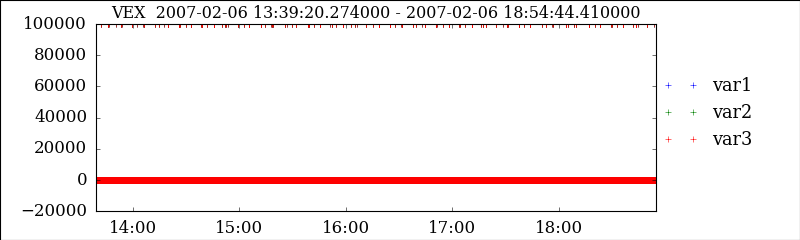

In [1]:
import sys, os, urllib
%matplotlib notebook
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from math import *
sys.path.append('../AnalysisMethods/')
import ANALYSIS as AN
import draw_attr as D
os.getcwd()

###################################################################################################################
'''DEFAULTS AND DATA FILES INPUTS'''
###################################################################################################################
## default Python version
pyv='Python2' ##'Python3' 


## defaults for all satellite data
default_input_path = '../Data/'
default_output_path='../Results/'


satellite='VEX'#'ULYSSES','CLUSTER','VEX'
probe='C3'#'C1','C2','C3','C4'
data_res=1. # default value of 1 s between measurements

if satellite=='CLUSTER':
    file_name=probe+'_CP_FGM_FULL__20080309_023112_20080309_040849_V080906.cdf'
elif satellite=='VEX':
    file_name='VEX_MAG_2007-02-06_133920-185444.txt'
    #file_name='MAG_20070206_DOY037_D001_V1.TAB'
    year='2007'
elif satellite=='ULYSSES':
    file_name='U01001SH.ASC'
    #file_name='U99081SH.ASC'    
else:
    print ('THE SATELLITE IS NOT SUPPORTED')    
###################################################################################################################


###################################################################################################################
'''GLOBAL VARIABLES'''
###################################################################################################################
flag=9999.
binno=100
choose_var_start=0 # choose first column of data to be analyzed, counting starts from 0
choose_var_stop=3 # choose last column of data to be analyzed, last column in the file 
###################################################################################################################


###################################################################################################################
'''RETRIEVE DATA FROM INPUT FILES'''
###################################################################################################################

if satellite=='CLUSTER':
    ALL_MAG_DATA, MAG_TIME, data_res=AN.CLUSTER_DATA_CDF(default_input_path,file_name,satellite,probe)
    data_freq=1./data_res
    print ('Magnetic resolution/cadence: ', data_res, 'Magnetic sampling frequency, Hz: ', str(data_freq)+' Hz')
elif satellite=='VEX': 
    ALL_MAG_DATA, MAG_TIME=AN.VEX_DATA_TXT(default_input_path,file_name,satellite,year) 
    data_res=1.
    data_freq=1./data_res
elif satellite=='ULYSSES': 
    ALL_MAG_DATA, MAG_TIME=AN.ULYSSES_DATA_ASC(default_input_path,file_name,satellite) 
    data_res=2.
    data_freq=1./data_res    
else:
    print ('NO SATELLITE SELECTED')

MAG_DATA=ALL_MAG_DATA[:,choose_var_start:choose_var_stop]    

'''!!!SET TRUE OR FALSE!!!'''
plot_data=True # choose if you want to plot data

if plot_data:
    mfig=AN.PLOT_DATA(MAG_DATA, MAG_TIME, satellite)
    
    '''!!!SET TRUE OR FALSE!!!'''
    save_data=False # choose if you want to save data
    if save_data:
        mfig.savefig(default_output_path+satellite+'_'+'DATA_'+str(MAG_TIME[0])[0:19]+'-'+str(MAG_TIME[-1])[10:19]+'.png')             
###################################################################################################################    

In [2]:
###################################################################################################################
'''SELECT DATA SUBSET / TRIM THE TIMESERIES '''
###################################################################################################################

'''!!!SET TRUE OR FALSE!!!'''
trim_TS=False
if trim_TS:
    if pyv=='Python2':
        t1=raw_input('Input START time in hhmmss format, e.g. 09:40:00 is 094000, and press ENTER/RETURN: ')
        t2=raw_input('Input STOP time in hhmmss format, e.g. 09:40:00 is 094000, and press ENTER/RETURN: ')
        print ('start and stop times:', t1, t2)
    elif pyv=='Python3':
        t1=input('Input START time in hhmmss format, e.g. 09:40:00 is 094000, and press ENTER/RETURN: ')
        t2=input('Input STOP time in hhmmss format, e.g. 09:40:00 is 094000, and press ENTER/RETURN: ')
        print ('start and stop times: ', t1, t2)        
    TRIMMED_MAG_TIME,TRIMMED_MAG_DATA=AN.CHOP_TS(str(t1),str(t2),MAG_TIME,MAG_DATA)
    print ('length of trimmed time series: ', len(TRIMMED_MAG_TIME))
else:
    TRIMMED_MAG_TIME,TRIMMED_MAG_DATA=MAG_TIME,MAG_DATA
    
'''!!!SET TRUE OR FALSE!!!'''
plot_trimmed_data=False # choose if you want to plot the trimmed data

if plot_trimmed_data:
    mfig=AN.PLOT_DATA(TRIMMED_MAG_DATA, TRIMMED_MAG_TIME, satellite) 
################################################################################################################### 

<IPython.core.display.Javascript object>


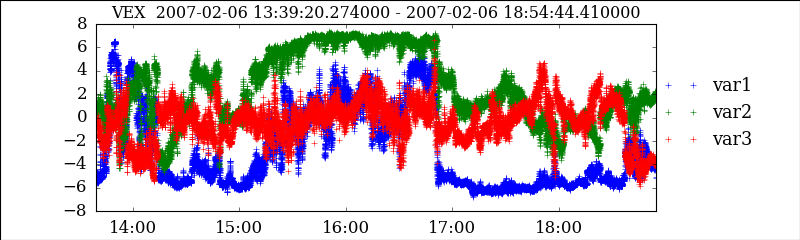

In [3]:
####################################################################################################################
'''DATA PRE-PROCESSING: data-gaps management - interpolate, flagg erroneous data'''
####################################################################################################################

### PRINT ERRONEOUS DATA - JUST PRINTING, NO MANAGEMENT OF DATA GAPS
'''!!!SET TRUE OR FALSE!!!'''
print_flags=False

if print_flags:
    AN.PRINT_FLAGS(flag, mag_time, MAG_DATA)

### MASK FLAGGED DATA ###
t_masked, t_maskedsec, MAG_DATA_MASKED = AN.MASK_ERRDATA(flag, TRIMMED_MAG_TIME, TRIMMED_MAG_DATA)

### PLOT MASKED DATA ###
'''!!!SET TRUE OR FALSE!!!'''
plot_masked_data=True # choose if you want to plot data

if plot_masked_data:
    mafig=AN.PLOT_DATA(MAG_DATA_MASKED,t_masked,satellite)
    '''!!!SET TRUE OR FALSE!!!'''
    save_standardized_data=True # choose if you want to save data
    if save_standardized_data:
        mafig.savefig(default_output_path+satellite+'_'+'MASKED_DATA_'+str(t_masked[0])[0:19]+'-'+str(t_masked[-1])[10:19]+'.png')             

### ADD FLAGGS WHERE THERE ARE GAPS IN TIME ###
t_pseudointerp, t_parsed, MAG_DATA_SELFFLAGGED = AN.SELF_FLAGG(data_res, t_maskedsec, MAG_DATA_MASKED)
####################################################################################################################

Welch segment length = 8.53 minutes


<IPython.core.display.Javascript object>


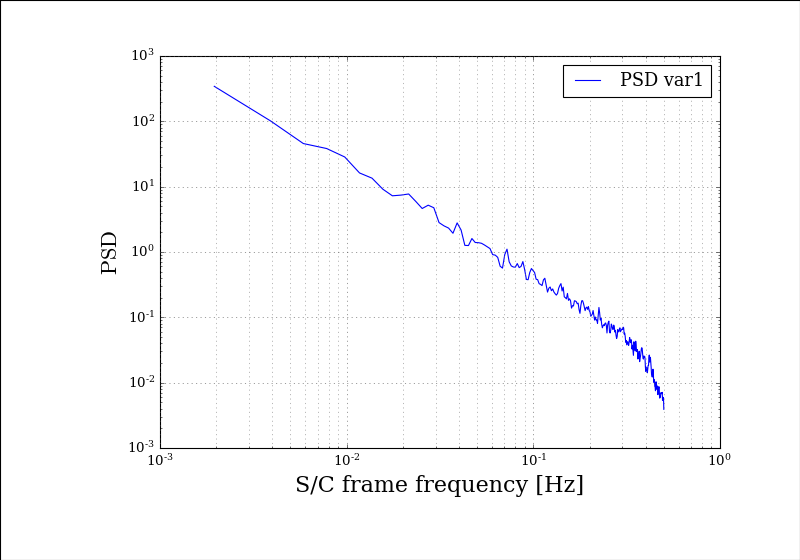

<IPython.core.display.Javascript object>


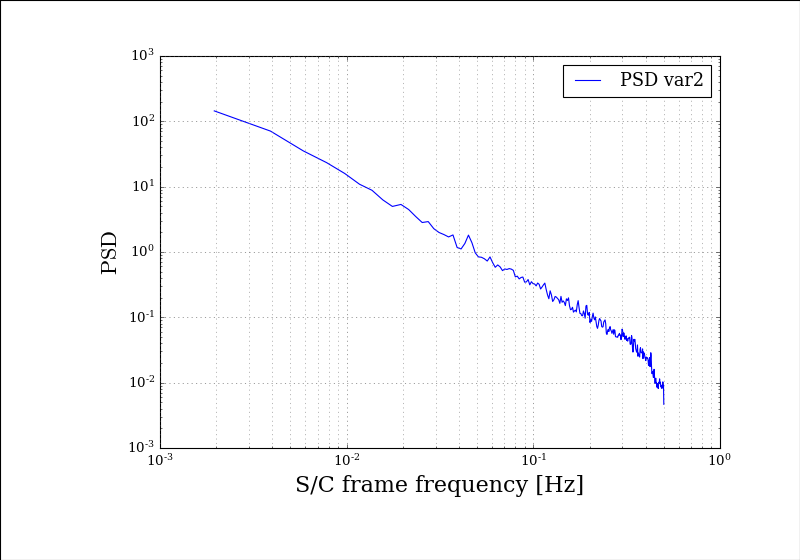

<IPython.core.display.Javascript object>


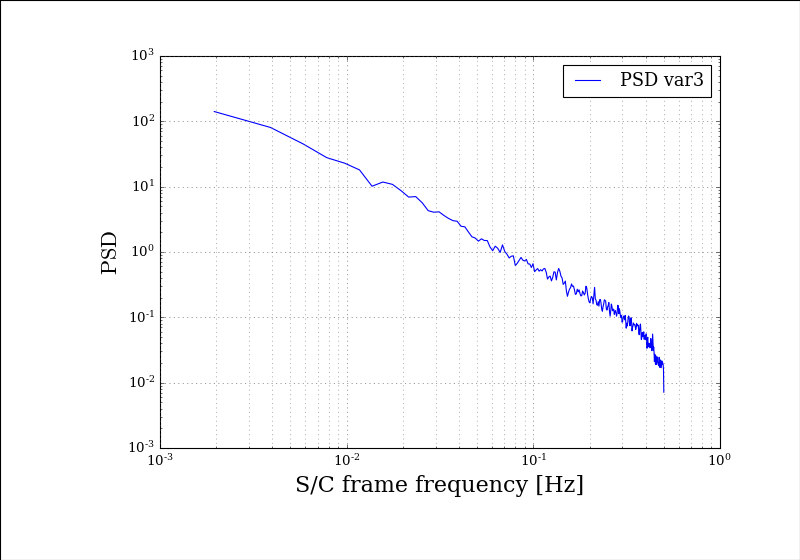

<IPython.core.display.Javascript object>


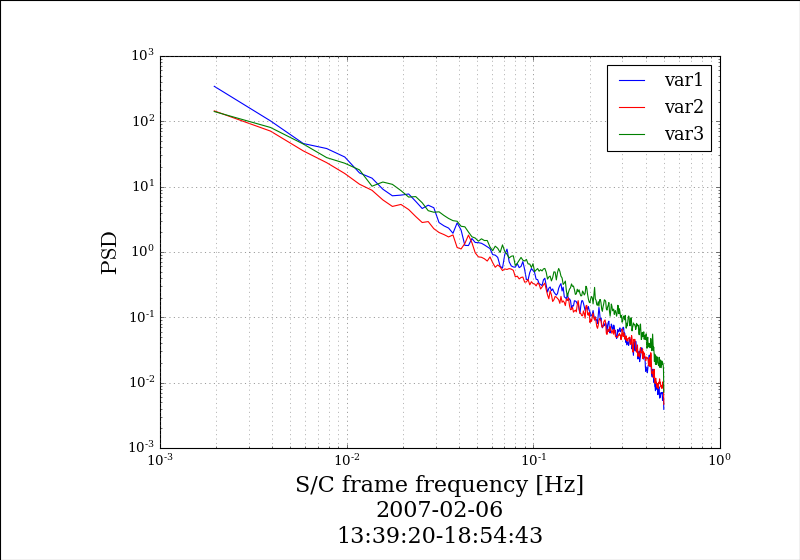

In [4]:
###################################################################################################################
'''PSD - COMPUTATION, PLOTTING, SAVING'''
###################################################################################################################

###PSD - COMPUTATION###

'''!!!SET TRUE OR FALSE!!!'''
compute_PSD=True

if compute_PSD:
    ###PSD Globals###
    psd_window, segment_magnitude, overlap_percent='hamming',512,0.9
        
    DATA_PSEUDOINT,freq,PSD,figures=AN.PSEUDOINTERP_PSD(data_freq,t_maskedsec,t_pseudointerp,MAG_DATA_MASKED, 
                                                        psd_window, segment_magnitude, overlap_percent) 

    ###PSD - PLOT###
    '''!!!SET TRUE OR FALSE!!!'''
    plot_PSD=True
    
    if plot_PSD:
        figPSD = plt.figure('figPSD', figsize = (10,7))
        p0=figPSD.add_axes([0.,0.,1.,1.])
        p0.axes.get_xaxis().set_visible(False)
        p0.axes.get_yaxis().set_visible(False)                    
        p = figPSD.add_axes([0.2,0.2,0.7,0.7])
        for i in range(len(PSD.keys())):
                p.loglog(freq,PSD[i], ms=5, c=D.myc[i],label='var'+str(i+1))
                l=p.legend()
        p.set_xlabel('S/C frame frequency [Hz]'+'\n'+str(t_parsed[0])[0:10]+'\n'+str(t_parsed[0])[11:19]+'-'+str(t_parsed[-1])[11:19], **D.lblpr)  
        p.set_ylabel(r'$\mathrm{PSD}$', **D.lblpr)
        p.xaxis.grid(True, **D.mingridprops)
        p.yaxis.grid(True, **D.majgridprops)
        p.xaxis.grid(True, **D.majgridprops)
        #p.yaxis.grid(True, **D.mingridprops)
        plt.show()


    ###PSD - SAVE PLOTS###
    
    '''!!!SET TRUE OR FALSE!!!'''
    save_individual_PSD=False
    save_allinone_PSD=True
    
    if save_individual_PSD:
        for i in range(len(figures)):
            figures[i].savefig(default_output_path+satellite+'_'+'PSD_'+str(t_parsed[0])[0:19]+'-'+str(t_parsed[-1])[10:19]+'_var'+str(i+1)+'.png')
    if save_allinone_PSD:        
        figPSD.savefig(default_output_path+satellite+'_'+'PSD_'+str(t_parsed[0])[0:19]+'-'+str(t_parsed[-1])[10:19]+'_allvar.png')    

    ###PSD - SAVE FREQUENCIES AND POWERS IN TXT FILE###   
###################################################################################################################    

<IPython.core.display.Javascript object>


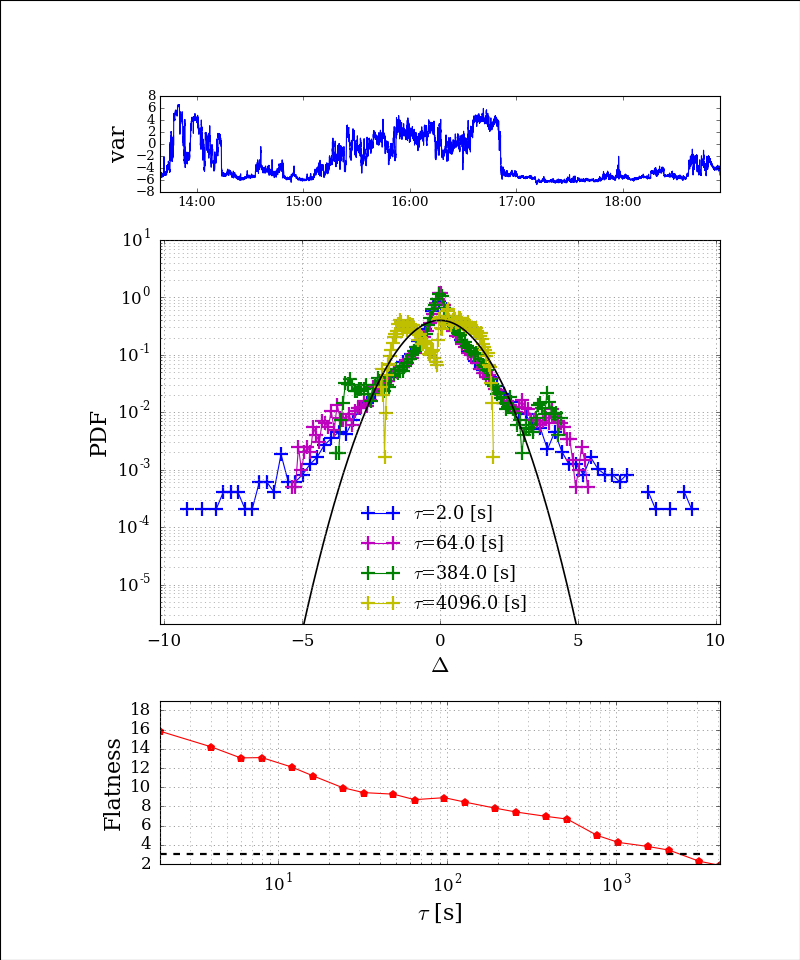

<IPython.core.display.Javascript object>


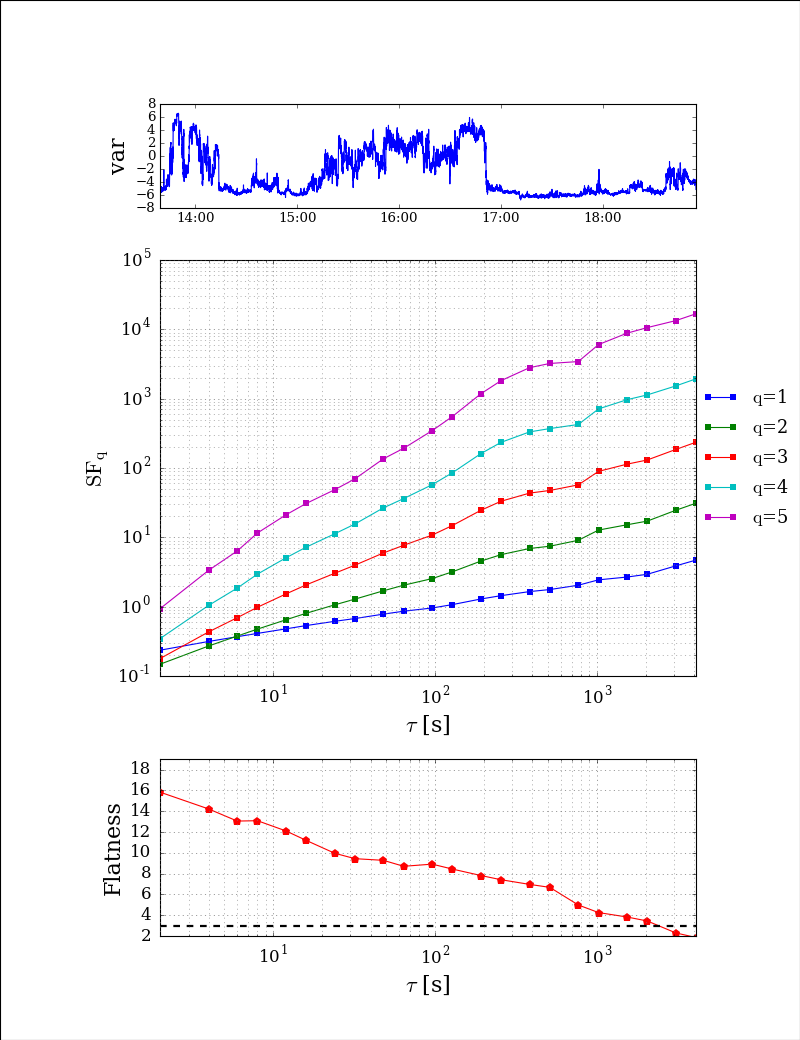

In [5]:
###################################################################################################################
'''PDF - COMPUTATION, PLOTTING, SAVING'''
###################################################################################################################

'''!!!SET TRUE OR FALSE!!!'''
compute_PDF=True

'''choose variable for which PDFs will be computed'''
choose_PDF_var=0 ## 0,1,2, etc correspond to data(!) columns

if compute_PDF:
    '''!!!SET TRUE OR FALSE!!!'''
    draw_PDF=True
    draw_SF=True
    save_PDF=True # True only of draw_PDF is true
    save_SF=True # True only of draw_SF is true

    PDF_var=MAG_DATA_MASKED[:,choose_PDF_var]
    max_scale=AN.maxscale(floor(len(PDF_var)/3))
    scl=AN.Scales(1, max_scale, True)
    rank=np.arange(1,6,1)
    PDFs,binc,Flatness,SF=AN.PDF(PDF_var,rank,scl,binno,draw_SF)

    if draw_PDF:
        figPDF=AN.DRAW_PDF(PDF_var,t_masked,scl,data_freq,binc,PDFs,Flatness)   
        if save_PDF:
            figPDF.savefig(default_output_path+satellite+'_'+'PDF_'+str(t_parsed[0])[0:19]+'-'+str(t_parsed[-1])[10:19]+'.png')
        
    if draw_SF:
        figSF=AN.DRAW_SF(PDF_var,t_masked,scl,data_freq,rank,SF,Flatness)    
        if save_SF:
            figSF.savefig(default_output_path+satellite+'_'+'SF_'+str(t_parsed[0])[0:19]+'-'+str(t_parsed[-1])[10:19]+'.png')
        
###################################################################################################################